# Revenue A/B Testing

## Table of Contents <a id='back'></a>

* [0. Import Data](#0)
* [1. General Information](#1)
* [2. Data Selection](#2)
* [3. Statistical Analysis](#3)
    * [3.1. Check normality](#31)
    * [3.2. Test Similarity of The Two Groups Revenues](#32)
    * [3.3. Inference using Bootstrapping](#33)
* [4. General Conclusion](#end)

**General Steps:**
1. Data Validation
2. Normality test
3. Hypothesis testing
4. Calculate confidence interval
5. Conclusion

## 0. Import Data<a id='0'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import shapiro, mannwhitneyu, norm
import statsmodels.api as sm
import pylab

In [2]:
df = pd.read_csv('AB_Test_Results.csv')

[back to table of contents](#back)

## 1. General Information<a id='1'></a>

In [3]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [5]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

Check if there is any users in both control and variant group.

In [6]:
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [7]:
double_variant_count / double_variant_count.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

[back to table of contents](#back)

## 2. Data Selection<a id='2'></a>

Select only data with single variant.

In [8]:
single_variant_count = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_variant_count = single_variant_count[single_variant_count]

Exclude double variant users.

In [9]:
df = df[df['USER_ID'].isin(single_variant_count.index)]
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

Plot the distribution for each variant.

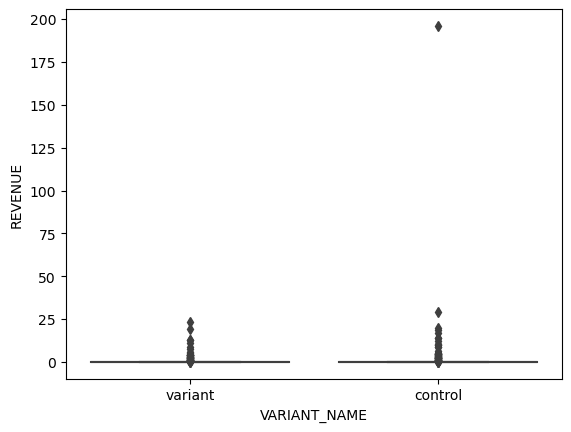

In [10]:
sns.boxplot(data=df, x='VARIANT_NAME', y='REVENUE')
plt.show()

There are many outliers.

Search for the outlier.

In [11]:
df.sort_values(by='REVENUE', ascending=False).iloc[:5]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [12]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


Remove outlier.

In [13]:
df = df[df['USER_ID'] != 3342]

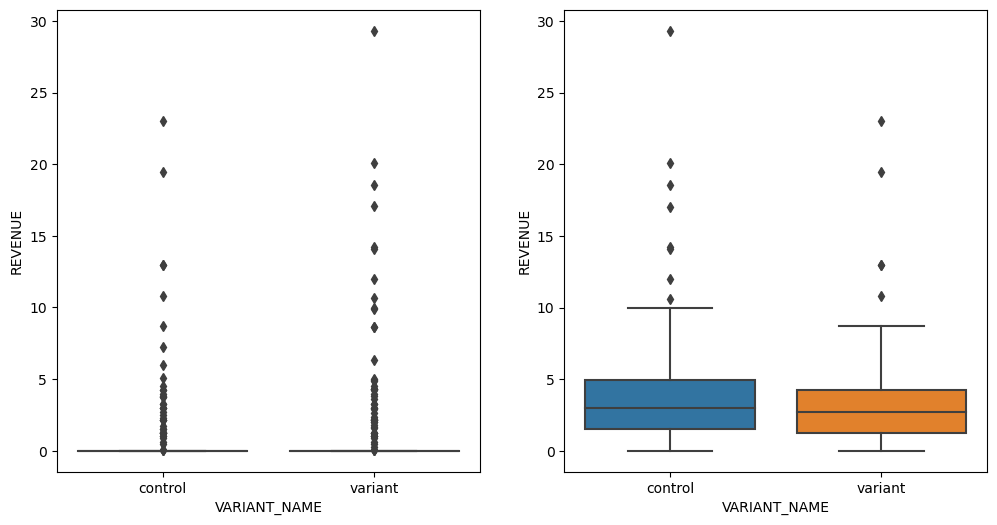

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,6))
sns.boxplot(data = df, x = 'VARIANT_NAME', y = 'REVENUE', ax = ax[0])
sns.boxplot(data = df[df['REVENUE'] > 0], x = 'VARIANT_NAME', y = 'REVENUE', ax = ax[1])
plt.xticks(np.arange(2), ('control', 'variant'))
plt.show()

Most of the users have no purchases. Let's see what kind of empty purchases these are: either this is information on all users, regardless of their actions (even in the absence of visits and positive purchases), or these records are put down in case of entry without purchases and there may be other records with positive revenue.

In [15]:
# let's see if there are users who have records with zero and positive revenue
df.groupby('USER_ID')['REVENUE'].nunique().value_counts()

1    4744
2      38
Name: REVENUE, dtype: int64

There are some users with both zero and positive revenue. We will just consider them as one.

In [16]:
df = df.groupby(['USER_ID', 'VARIANT_NAME']).sum().reset_index()

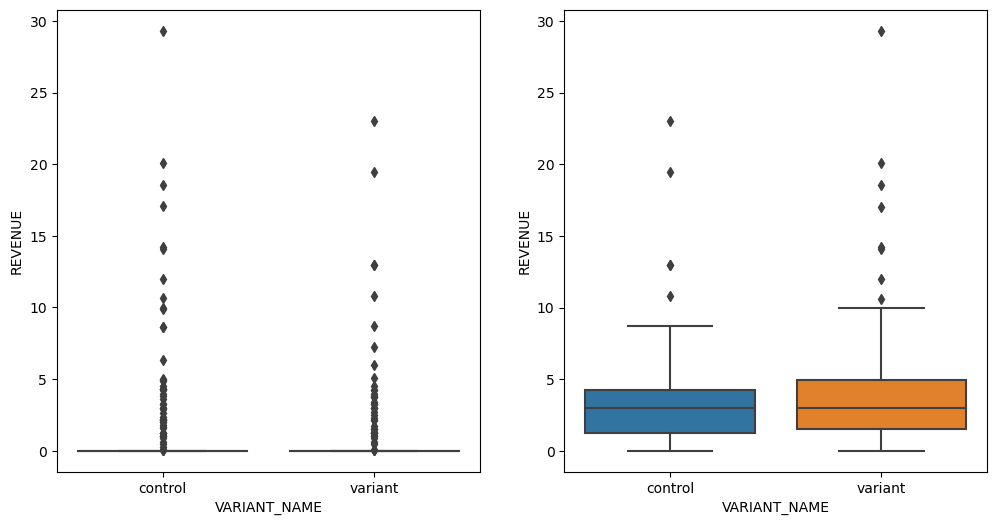

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,6))
sns.boxplot(data = df, x = 'VARIANT_NAME', y = 'REVENUE', ax = ax[0])
sns.boxplot(data = df[df['REVENUE'] > 0], x = 'VARIANT_NAME', y = 'REVENUE', ax = ax[1])
plt.xticks(np.arange(2), ('control', 'variant'))
plt.show()

The quantiles in the test group increased slightly.

In [18]:
all_stat = df.groupby('VARIANT_NAME').agg({'USER_ID': 'nunique', 'REVENUE': ['sum', 'mean', 'median', 'count']})

orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

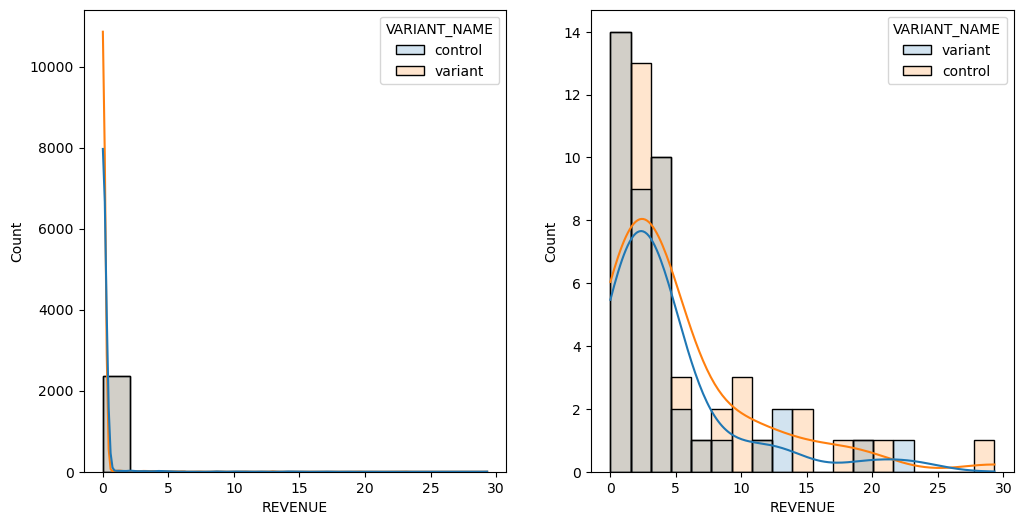

In [19]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,6))
sns.histplot(data = df, x = 'REVENUE', hue = 'VARIANT_NAME', kde = True, alpha=0.2, ax = ax[0])
sns.histplot(data = df[df['REVENUE'] > 0], x = 'REVENUE', hue = 'VARIANT_NAME', kde = True, alpha=0.2, ax = ax[1])
plt.show()

Revenue data doesn't seem to follow normal distribution. It is right-skewed.

[back to table of contents](#back)

## 3. Statistical Analysis<a id='3'></a>

### 3.1. Check normality<a id='31'></a>

H0: Revenue for variant group is normally distributed.<br>
H1: Revenue for variant group is not normally distributed.

In [20]:
alpha = 0.05

In [21]:
result = shapiro(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'])
if result.pvalue < alpha:
    print('Reject H0: Revenue for variant group is not normally distributed.')
else:
    print('Failed to reject H0: Revenue for variant group is normally distributed.')

Reject H0: Revenue for variant group is not normally distributed.


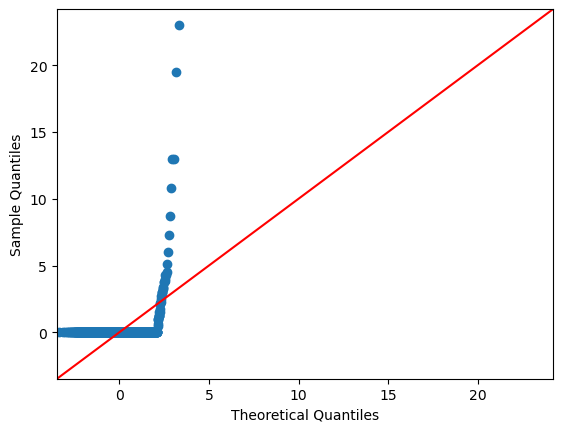

In [22]:
sm.qqplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], line='45')
pylab.show()

Sample quantiles tends to be higher than theoretical quantiles. This means that the data is skewed to the right and grows exponentially for several last quantile.

[back to table of contents](#back)

### 3.2. Test Similarity of The Two Groups Revenues<a id='32'></a>

Because the data is not normal, we will use non-parametric Mann Whitney U Test instead of T-Test.

H0: Revenues for variant and control group are the same.<br>
H1: Revenues for variant and control group are not same.

Because there are many data with 0 value, we will test it both on all data and only data with non-zero values.

In [23]:
result = mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])
if result.pvalue < alpha:
    print('Reject H0: Revenues for variant and control group for all data are not the same.')
else:
    print('Failed to reject H0: Revenues for variant and control group for all data are the same.')

Failed to reject H0: Revenues for variant and control group for all data are the same.


In [24]:
result = mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])
if result.pvalue < alpha:
    print('Reject H0: Revenues for variant and control group for non-zero data are not the same.')
else:
    print('Failed to reject H0: Revenues for variant and control group for non-zero data are the same.')

Failed to reject H0: Revenues for variant and control group for non-zero data are the same.


[back to table of contents](#back)

### 3.3. Inference using Bootstrapping<a id='33'></a>

In [25]:
def get_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [26]:
control = get_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

control_paid = get_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

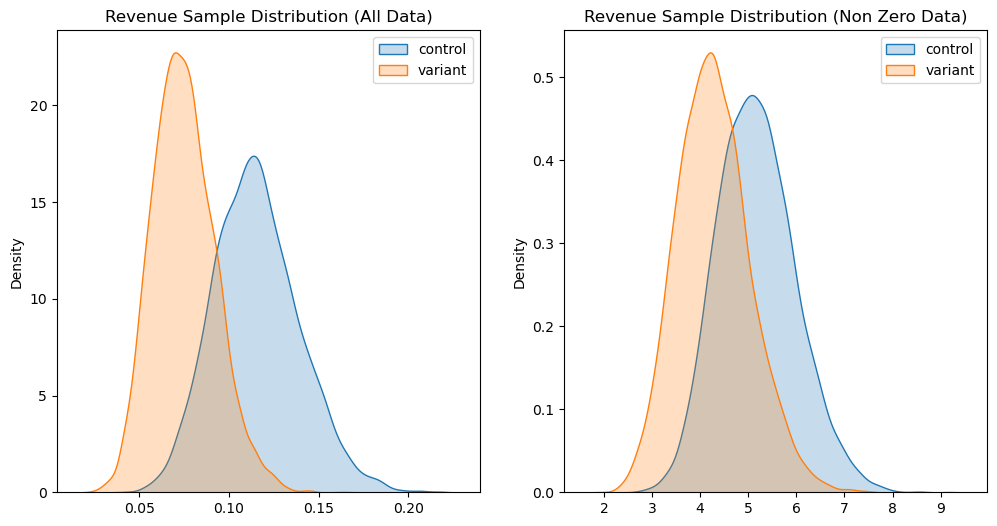

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.kdeplot(np.mean(control, axis=1), fill=True, label='control', ax=ax[0])
sns.kdeplot(np.mean(variant, axis=1), fill=True, label='variant', ax=ax[0])
sns.kdeplot(np.mean(control_paid, axis=1), fill=True, label='control', ax=ax[1])
sns.kdeplot(np.mean(variant_paid, axis=1), fill=True, label='variant', ax=ax[1])
ax[0].set_title('Revenue Sample Distribution (All Data)')
ax[1].set_title('Revenue Sample Distribution (Non Zero Data)')
ax[0].legend()
ax[1].legend()
plt.show()

We can see that the samples mean between the two groups has a large overlap.

In [28]:
control_means = np.mean(control, axis=1)
variant_means = np.mean(variant, axis=1)

control_low, control_high = st.norm.interval(confidence=0.95, loc=control_means.mean(), scale=control_means.std(ddof=1))
variant_low, variant_high = st.norm.interval(confidence=0.95, loc=variant_means.mean(), scale=variant_means.std(ddof=1))
print(f'We are 95% confident that the mean for control group revenue is between {control_low:.3f} and {control_high:.3f}')
print(f'We are 95% confident that the mean for variant group revenue is between {variant_low:.3f} and {variant_high:.3f}')

We are 95% confident that the mean for control group revenue is between 0.068 and 0.162
We are 95% confident that the mean for variant group revenue is between 0.041 and 0.109


In [29]:
control_means_paid = np.mean(control_paid, axis=1)
variant_means_paid = np.mean(variant_paid, axis=1)

control_low_paid, control_high_paid = st.norm.interval(confidence=0.95, loc=control_means_paid.mean(), scale=control_means_paid.std(ddof=1))
variant_low_paid, variant_high_paid = st.norm.interval(confidence=0.95, loc=variant_means_paid.mean(), scale=variant_means_paid.std(ddof=1))
print(f'We are 95% confident that the mean for control group revenue (non-zero) is between {control_low_paid:.3f} and {control_high_paid:.3f}')
print(f'We are 95% confident that the mean for variant group revenue (non-zero) is between {variant_low_paid:.3f} and {variant_high_paid:.3f}')

We are 95% confident that the mean for control group revenue (non-zero) is between 3.574 and 6.755
We are 95% confident that the mean for variant group revenue (non-zero) is between 2.784 and 5.767


[back to table of contents](#back)

## 4. Conclusion<a id='4'></a>

The key findings in this research are:
* The revenue distribution between control and variant group don't follow normal distribution.
* Based on Mann Whitney U Test with level of significance of 0.05, the revenues for variant and control group for both all and non-zero data are the same. The change isn't significant enough to change to newer version.
* By plotting the sampling distribution, and generating 95% confidence interval, we can see that there are a lot of overlap between the two groups.

Recommendation:
* Keep using the existing option because there are not significant enough change in revenue.

[back to table of contents](#back)